In [10]:
import json, re, os
from dataclasses import dataclass
from typing import Literal
from openai import OpenAI
from dotenv import load_dotenv

In [12]:
load_dotenv()  # load variables from .env
API_KEY = os.getenv("OPENAI_API_KEY")
if not API_KEY:
    raise ValueError("Missing OPENAI_API_KEY environment variable")

client = OpenAI(api_key=API_KEY)

In [13]:
# --- Multi-check user story grader (boolean tags) with early-exit + progress ---
import os, time, random, re, json
from typing import Dict, Any, List, Tuple, Union
from dataclasses import dataclass
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm  # pip install tqdm

# ====================== CONFIG ======================
MODEL = "gpt-4o"
TEMPERATURE = 0.0

# Allow small JSON outputs
JSON_MAX_TOKENS = 120

RETRIES = 5
BASE_DELAY = 2.0  # Increased base delay
GLOBAL_CALL_DELAY = 1.0  # Much longer delay between requests

# Paste your ALREADY_DONE exactly as you have it:
ALREADY_DONE = """
The app ALREADY implements these 5 user stories. Any new story that duplicates or trivially rephrases one of these should be considered a duplicate (grade low and say it is already implemented).

1) Sign-in / Login
   As a user, I want to sign up/log in so that my ToDos persist across devices.
   Includes: Google sign-in via Firebase Auth, success message after login.

2) Create / Add a ToDo
   As a user, I want to create a new ToDo so that I can add tasks to my list.
   Includes: Title (required), description, assignee, location, due date; validation; save to Firestore.

3) List of ToDos
   As a user, I want to view a list of my ToDos so that I can see pending tasks.
   Includes: Scrollable list, empty-state prompt, title per item, auto-updates after changes, fetched post-login, navigation menu.

4) Edit a ToDo
   As a user, I want to edit and view details of my ToDos so that I can update tasks or review details.
   Includes: Tap list item → editable detail view (title, description, assignee, location, due date, state), save/delete to Firestore, return to list reflecting changes.
   NOTE: “Mark a ToDo completed” is covered here via state changes.

5) Location-based ToDos
   As a user, I want to geo-locate ToDos and see them on a map so that I can plan work by location.
   Includes: Set location in create/edit; Nominatim reverse geocoding; map view with pins; tap pin shows title/description; Google Maps rendering.
"""

# Enable/disable specific checks if needed
ENABLED_CHECKS = {
    "duplicate": True,
    "irrelevant": True,
    "vague": True,
    "oversized": True,
    "role-mismatch": True,
    "ui-polish": True,
    "typo": True,
    "bad-structure": True,   # NEW CRITERION
}

# Checks are prioritized so we can early-exit on duplicate/irrelevant
PRIORITY_CHECKS = ["duplicate", "irrelevant"]
OTHER_CHECKS_ORDER = ["typo", "oversized", "role-mismatch", "ui-polish", "bad-structure", "vague"]

# ================== PROMPT FRAMING (updated) ==================
SYSTEM_HEADER = (
    "You are acting as a teacher grading a user story for a ToDo app.\n"
    "The app ALREADY IMPLEMENTS the following 5 user stories. If a student repeats any of these or trivially rephrases them, that is a DUPLICATE:\n\n"
    + ALREADY_DONE +
    "\nYou will be given a single criterion to check.\n"
    "Return ONLY the word true or false (lowercase), with no punctuation or explanation."
)

# ================== CHECK DEFINITIONS (your wording preserved) ==================
CHECK_DEFS: Dict[str, str] = {
    "duplicate": (
        "DUPLICATE: Return true ONLY if the user story is the SAME AS or a TRIVIAL REPHRASING of one of the 5 ALREADY IMPLEMENTED stories listed in the system prompt, "
        "including their explicit sub-actions:\n"
        "  (1) sign-in/login with Google (Firebase)\n"
        "  (2) create/add a ToDo (title, description, assignee, location, due date, validation, save to Firestore)\n"
        "  (3) list/view ToDos (scrollable, empty-state, auto-updates, fetched after login, navigation)\n"
        "  (4) edit/view a ToDo (edit title/description/assignee/location/due date/state; delete; save; return to list)\n"
        "  (5) location-based ToDos (set location; reverse-geocoding; map with pins; tapping pin shows title/description; Google Maps rendering)\n"
        "Count as duplicate if the story asks for any of these same outcomes even with different wording (e.g., 'delete a task from its detail screen', "
        "'show my ToDos on a Google Map with pins', 'go back to the list after saving a task', 'reverse-geocode an address for a task').\n"
        "Do NOT mark as duplicate features like reminders/notifications, tags/categories, priorities, search/filter/sort, recurring tasks, subtasks/checklists, "
        "attachments, archive, snooze, collaboration/sharing, timers/time-tracking, UI themes/dark mode, onboarding, or similar new capabilities.\n"
        "Minor typos or synonyms do not change the essence. If uncertain, return false."
    ),
    "irrelevant": (
        "IRRELEVANT: Return true ONLY if the story is completely outside the scope of a ToDo/task management application "
        "(e.g., booking flights, ordering food, running a business). "
        "Return false if the story is related to tasks/ToDos OR the application’s user experience (UI, themes, dark mode, accessibility, navigation). "
    ),
    "vague": (
        "VAGUE: Return true ONLY if the story is missing essential details in role, action, or benefit "
        "(e.g., 'As a user, I want to do things so that stuff works'). "
        "Return false if the story gives a clear action and benefit, even if subjective (e.g., dark mode for eye comfort). "
        "UI or polish-related stories with a stated benefit are NEVER vague."
    ),
    "oversized": (
        "OVERSIZED: Return true ONLY if the story requests multiple distinct, unrelated features.\n"
        "Consider these as SINGLE features (return false):\n"
        "- Related actions for one goal: 'create groups and assign tasks' (team management)\n"
        "- Sequential steps: 'add task and set reminder' (task creation workflow)\n"
        "- Feature with configuration: 'dark mode and custom colors' (theming)\n"
        "- Natural complements: 'search and filter tasks' (finding tasks)\n"
        "Return true ONLY for clearly separate features:\n"
        "- 'add tasks and book flights' (unrelated domains)\n"
        "- 'create todos and play music and send emails' (multiple distinct features)\n"
        "If actions work together toward one user goal, it's one feature."
    ),
    "role-mismatch": (
    "ROLE-MISMATCH: Return true ONLY if the role is completely inappropriate for a ToDo app user.\n"
    "Accept these types of roles:\n"
    "- Individual users: user, student, grandpa, parent, teacher, employee, etc.\n"
    "- Organizational roles: manager, team leader, supervisor, coordinator, etc.\n"
    "- Users with characteristics: busy user, old user, blind user, etc.\n"
    "Return true ONLY for roles that make no sense in a ToDo context:\n"
    "- Non-human: dog, cat, robot, AI, system\n"
    "- Completely unrelated: customer buying groceries, patient in hospital\n"
    "If no role is present, return false (bad-structure handles missing roles)."
),
    "ui-polish": (
        "UI-POLISH: Return true if the story is mainly a UI/visual tweak or comfort feature without adding core ToDo functionality "
        "(e.g., themes, animations, onboarding tour, dark mode). Return false otherwise."
    ),
    "typo": (
        "TYPO: Return true if the user story contains obvious spelling/grammar typos (e.g., misspelled words, malformed sentences). "
        "Return false if the text is clean."
    ),
    "bad-structure": (
        "Check if the story contains ALL THREE phrases: 'As a', 'I want', and 'so that'.\n"
        "Return true ONLY if any phrase is missing.\n"
        "Return false if all three phrases are present.\n"
        "Examples:\n"
        "'As a user, I want to collaborate with my friends on tasks' - missing 'so that' = TRUE\n"
        "'I want to add tasks so that I can track them' - missing 'As a' = TRUE\n"
        "'As a user, I want to add tasks so that I can track my work' - has all three = FALSE"
    )
}

# ================== JSON CALL ==================
def _extract_json_obj(text: str) -> dict:
    text = (text or "").strip()
    try:
        obj = json.loads(text)
        if isinstance(obj, dict):
            return obj
    except Exception:
        pass
    m = re.search(r"\{.*\}", text, flags=re.DOTALL)
    if not m:
        raise ValueError(f"Expected JSON object, got: {text!r}")
    return json.loads(m.group(0))

def _ask_all_checks(story: str, enabled_keys: List[str]) -> Dict[str, bool]:
    criteria_lines = [f"{key}: {CHECK_DEFS[key]}" for key in enabled_keys]
    example_pairs = ", ".join([f"\"{k}\": false" for k in enabled_keys])

    schema_hint = (
        "Return ONLY a strict JSON object with each requested key set to true or false.\n"
        f"Example: {{{example_pairs}}}\n"
        "No prose, no comments, no trailing text."
    )

    user_msg = (
        "Criterion bundle (evaluate ALL independently and set booleans):\n"
        + "\n\n".join(criteria_lines)
        + f"\n\nUser story:\n\"\"\"\n{story}\n\"\"\"\n\n{schema_hint}"
    )

    last_err = None
    for attempt in range(1, RETRIES + 1):
        try:
            time.sleep(GLOBAL_CALL_DELAY)
            resp = client.chat.completions.create(
                model=MODEL,
                temperature=TEMPERATURE,
                max_tokens=JSON_MAX_TOKENS,
                messages=[
                    {"role": "system", "content": SYSTEM_HEADER},
                    {"role": "user", "content": user_msg},
                ],
            )
            raw = resp.choices[0].message.content
            obj = _extract_json_obj(raw)

            out: Dict[str, bool] = {}
            for k in enabled_keys:
                v = obj.get(k, False)
                out[k] = bool(v) if isinstance(v, (bool, int)) else str(v).strip().lower() == "true"
            return out
        except Exception as e:
            last_err = e
            # Check if it's a rate limit error and wait longer
            if "rate_limit_exceeded" in str(e) or "429" in str(e):
                sleep_s = 1 + random.uniform(0, 2)  # Wait 60-90 seconds for rate limits
                print(f"Rate limit hit, waiting {sleep_s:.1f}s...")
            else:
                sleep_s = BASE_DELAY * (2 ** (attempt - 1)) + random.uniform(0, 0.3)
            time.sleep(sleep_s)
    raise RuntimeError(f"JSON check failed after {RETRIES} attempts: {last_err}")

# ================== STORY CHECK ==================
@dataclass
class StoryChecks:
    story: str
    booleans: Dict[str, bool]
    tags: List[str]

def run_checks_for_story(story: str, enabled: Dict[str, bool] = ENABLED_CHECKS) -> StoryChecks:
    enabled_keys = [k for k, on in enabled.items() if on]
    bools = _ask_all_checks(story, enabled_keys)

    # Early exit
    # early = []
    # if bools.get("duplicate", False):
    #     early.append("duplicate")
    # if bools.get("irrelevant", False):
    #     early.append("irrelevant")
    # if early:
    #     for k in bools.keys():
    #         if k not in ("duplicate", "irrelevant", "bad-structure"):
    #             bools[k] = False
    #     return StoryChecks(story, bools, early)

    tags = [k for k, v in bools.items() if v]
    return StoryChecks(story, bools, tags)

# ================== BATCH RUN ==================
def run_checks_batch(stories: List[str], concurrency: int = 6) -> List[StoryChecks]:
    results: List[Union[StoryChecks, None]] = [None] * len(stories)

    def _worker(i: int, s: str):
        return i, run_checks_for_story(s)

    with ThreadPoolExecutor(max_workers=concurrency) as ex, \
         tqdm(total=len(stories), desc="Checking stories", unit="story") as pbar:
        futures = [ex.submit(_worker, i, s) for i, s in enumerate(stories)]
        for fut in as_completed(futures):
            i, sc = fut.result()
            results[i] = sc
            pbar.update(1)

    return results  # type: ignore

# ================== EXAMPLES ==================
EXAMPLES = [
"As a user, I want to add a tag to some of my To-Dos and filtering, so that I can filter them by their tag.",
"As a manager, I would like to be able to create groups and assign ToDos to my team to improve collaboration",
"As a user, I want subtasks and notifications so that I can break work into steps and track progress."

]

if __name__ == "__main__":
    out = run_checks_batch(EXAMPLES, concurrency=4)
    for r in out:
        print("\nStory:", r.story)
        print("Tags :", r.tags)
        print("Flags:", {k: int(v) for k, v in r.booleans.items()})

Checking stories:   0%|          | 0/3 [00:00<?, ?story/s]

Checking stories: 100%|██████████| 3/3 [00:03<00:00,  1.28s/story]


Story: As a user, I want to add a tag to some of my To-Dos and filtering, so that I can filter them by their tag.
Tags : []
Flags: {'duplicate': 0, 'irrelevant': 0, 'vague': 0, 'oversized': 0, 'role-mismatch': 0, 'ui-polish': 0, 'typo': 0, 'bad-structure': 0}

Story: As a manager, I would like to be able to create groups and assign ToDos to my team to improve collaboration
Tags : []
Flags: {'duplicate': 0, 'irrelevant': 0, 'vague': 0, 'oversized': 0, 'role-mismatch': 0, 'ui-polish': 0, 'typo': 0, 'bad-structure': 0}

Story: As a user, I want subtasks and notifications so that I can break work into steps and track progress.
Tags : ['oversized']
Flags: {'duplicate': 0, 'irrelevant': 0, 'vague': 0, 'oversized': 1, 'role-mismatch': 0, 'ui-polish': 0, 'typo': 0, 'bad-structure': 0}


In [25]:
# ==================== 100 Mixed User Stories Test Suite =====================
from collections import Counter, defaultdict
from tqdm import tqdm

def _t(story, *tags):
    # tags must match your checker names: duplicate, irrelevant, vague, oversized, role-mismatch, ui-polish, typo
    # if no flaw is expected, pass None
    clean_tags = [t for t in tags if t is not None]
    return {"story": story, "expected": clean_tags}

TESTS = []

# ---- [duplicate] ----
# TESTS += [
#     _t("As a user, I want to log in with Google so that my ToDos sync across devices.", "duplicate"),
#     _t("As a user, I want to sign up and log in so that my tasks persist between sessions.", "duplicate"),
#     _t("As a user, I want to create a ToDo with title and due date so that I can track work.", "duplicate"),
#     _t("As a user, I want to add a new task with description and assignee so that I can assign work.", "duplicate"),
#     _t("As a user, I want to view a list of my ToDos so that I can see pending tasks.", "duplicate"),
#     _t("As a user, I want the list of ToDos to update automatically after edits.", "duplicate"),
#     _t("As a user, I want to edit a ToDo’s details so that I can correct info.", "duplicate"),
#     _t("As a user, I want to delete a ToDo from its detail screen.", "duplicate"),
#     _t("As a user, I want to mark a ToDo as completed so that I can track progress.", "duplicate"),
#     _t("As a user, I want to set a location on a ToDo so that I can see it on a map.", "duplicate"),
#     _t("As a user, I want to view my ToDos on a map with pins.", "duplicate"),
#     _t("As a user, I want to reverse-geocode locations for my ToDos.", "duplicate"),
#     _t("As a user, I want the map view to use Google Maps so that I can see my ToDos.", "duplicate"),
#     _t("As a user, I want to go back from the ToDo editor to the list after saving.", "duplicate"),
#     _t("As a user, I want to create a new task so that I can track my work.", "duplicate"),
#     _t("As a user, I want to set a due date so that I finish tasks on time.", "duplicate"),
#     _t("As a user, I want to mark tasks as complete so that I see my progress.", "duplicate"),
#     _t("As a user, I want to add a description to a task so that I remember details.", "duplicate"),
#     _t("As a user, I want to assign a task to someone so that responsibilities are clear.", "duplicate"),
#     _t("As a user, I want to delete tasks so that I remove things I no longer need.", "duplicate"),
#     _t("As a user, I want to view my tasks in a list so that I know what I need to do.", "duplicate"),
#     _t("As a user, I want to edit a task so that I can update its details.", "duplicate"),
#     _t("As a user, I want to see my ToDos on a map so that I can plan by location.", "duplicate"),
# ]

# # ---- [irrelevant] ----
# TESTS += [
#     _t("As a traveler, I want to book flights so that I can plan my trips.", "irrelevant"),
#     _t("As a gamer, I want to save high scores so that I can track my performance.", "irrelevant"),
#     _t("As a shopper, I want to track discounts so that I buy at lower prices.", "irrelevant"),
#     _t("As a viewer, I want to stream movies so that I can watch new releases.", "irrelevant"),
#     _t("As a foodie, I want to order meals so that I can eat at home.", "irrelevant"),
#     _t("As a banker, I want to trade stocks so that I grow my portfolio.", "irrelevant"),
#     _t("As a student, I want to view exam results so that I know my grades.", "irrelevant"),
#     _t("As a driver, I want traffic alerts so that I avoid delays.", "irrelevant"),
#     _t("As a patient, I want to book doctor appointments so that I can see a specialist.", "irrelevant"),
#     _t("As a tourist, I want museum tickets so that I can enter quickly.", "irrelevant"),
#     _t("As a reader, I want book recommendations so that I can discover novels.", "irrelevant"),
#     _t("As a music fan, I want to create playlists so that I can listen to songs.", "irrelevant"),
#     _t("As a customer, I want product reviews so that I can choose better items.", "irrelevant"),
#     _t("As a sports fan, I want live match stats so that I can follow my team.", "irrelevant"),
# ]

# # ---- [ui-polish] ----
# TESTS += [
#     _t("As a user, I want dark mode so that my eyes don’t hurt at night.", "ui-polish"),
#     _t("As a user, I want custom themes so that the app matches my taste.", "ui-polish"),
#     _t("As a user, I want adjustable font size so that text is easier to read.", "ui-polish"),
#     _t("As a user, I want subtle animations so that the app feels smooth.", "ui-polish"),
#     _t("As a user, I want compact list density so that I see more tasks at once.", "ui-polish"),
#     _t("As a user, I want a minimalist mode so that the UI feels less cluttered.", "ui-polish"),
#     _t("As a user, I want a welcome tour so that I can learn the app quickly.", "ui-polish"),
#     _t("As a user, I want an icon badge with task counts so that I see pending work.", "ui-polish"),
#     _t("As a user, I want customizable swipe gestures so that I act quickly.", "ui-polish"),
#     _t("As a user, I want haptic feedback on actions so that interactions feel responsive.", "ui-polish"),
#     _t("As a user, I want high-contrast mode so that content is legible.", "ui-polish"),
#     _t("As a user, I want larger tap targets so that actions are easier on mobile.", "ui-polish"),
#     _t("As a user, I want a cleaner task card layout so that information is scannable.", "ui-polish"),
#     _t("As a user, I want color-blind friendly palettes so that I can distinguish states.", "ui-polish"),
# ]

# ---- [vague] ----
TESTS += [
    _t("As a user, I want improvements so that it is better.", "vague"),
    _t("As a user, I want more options so that I have flexibility.", "vague"),
    _t("As a user, I want enhancements so that I am productive.", "vague"),
    _t("As a user, I want to do things so that it is useful.", "vague"),
    _t("As a user, I want support so that I’m satisfied.", "vague"),
    _t("As a user, I want efficiency so that I save time.", "vague"),
    _t("As a user, I want features so that I can benefit.", "vague"),
    _t("As a user, I want changes so that the app improves.", "vague"),
    _t("As a user, I want it to be faster so that it’s good.", "vague"),
    _t("As a user, I want everything so that life is easier.", "vague"),
    _t("As a user, I want enhancements to tasks so that it helps.", "vague"),
]

# # ---- [oversized] ----
# TESTS += [
#     _t("As a user, I want to have reminders and recurring tasks so that I never forget things.", "oversized"),
#     _t("As a user, I want to add tags and priorities so that I can organize my tasks better.", "oversized"),
#     _t("As a user, I want subtasks and notifications so that I can break work into steps and track progress.", "oversized"),
#     _t("As a user, I want to filter tasks and share them with others so that collaboration is easier.", "oversized"),
#     _t("As a user, I want offline support and syncing across devices so that I always have my tasks.", "oversized"),
# ]

# # ---- [role-mismatch] ----
# TESTS += [
#     _t("As an admin, I want to delete any user’s tasks so that the system stays clean.", "role-mismatch"),
#     _t("As a moderator, I want to edit others’ tasks so that rules are enforced.", "role-mismatch"),
#     _t("As a superuser, I want to view all private tasks so that I can audit activity.", "role-mismatch"),
#     _t("As HR, I want to see employees’ personal tasks so that I can assess productivity.", "role-mismatch"),
#     _t("As a reviewer, I want to approve other users’ tasks so that quality is ensured.", "role-mismatch"),
#     _t("As an auditor, I want access to all task histories so that compliance is verified.", "role-mismatch"),
#     _t("As a manager, I want to reassign anyone’s tasks so that workload is controlled.", "role-mismatch"),
#     _t("As a super admin, I want to reset users’ accounts so that they start fresh.", "role-mismatch"),
# ]

# # ---- [typo] ----
# TESTS += [
#     _t("As a usr, I wnt dark mode so that my eys don’t hurt at nite.", "typo", "ui-polish"),
#     _t("As a user, I want recuring ToDos so that I dont need to re-enter taks.", "typo"),
#     _t("As a user, I want a srch bar so that I can find tasks fst.", "typo"),
#     _t("As a user, I want subtasks so that big tasx are split.", "typo"),
#     _t("As a user, I want filtres so that I can focs on what matters.", "typo"),
#     _t("As a user, I want setting a tag so that tasks are organzed.", "typo"),
#     _t("As a user, I want snooze tasks so that I can dely them.", "typo"),
#     _t("As a user, I want archive ToDos so that my list stays cleen.", "typo"),
#     _t("As a user, I want attach fils so that docs stay togther.", "typo"),
#     _t("As a user, I want overdue vew so that I can act quikly.", "typo"),
# ]

# # ---- [perfect] ----
# TESTS += [
#     _t("As a user, I want to tag my tasks so that I can organize them by topic.", None),
#     _t("As a user, I want to set priority on tasks so that I focus on the most important ones first.", None),
#     _t("As a user, I want recurring tasks so that I don’t have to re-create repeating work.", None),
#     _t("As a user, I want reminders for tasks so that I don’t miss deadlines.", None),
#     _t("As a user, I want to search tasks by keyword so that I can quickly find what I need.", None),
#     _t("As a user, I want to filter tasks by tag or assignee so that I can focus on a subset.", None),
#     _t("As a user, I want to sort tasks by due date or priority so that I see what matters first.", None),
#     _t("As a user, I want to add subtasks to a task so that I can break work into steps.", None),
#     _t("As a user, I want to attach files to a task so that related documents stay together.", None),
#     _t("As a user, I want an Overdue view so that I can quickly act on late tasks.", None),
# ]

# --------------------- Run and Compare ---------------------
stories = [t["story"] for t in TESTS]

# run model in batches
all_results = []
for i in range(0, len(stories), 20):
    batch = stories[i:i+20]
    batch_results = run_checks_batch(batch, concurrency=5)
    all_results.extend(batch_results)

pred = all_results  # <--- FIX: now pred is defined

# Convert predictions to sets; apply early-exit expectation for duplicate/irrelevant
pred_sets = []
for r in pred:
    pred_sets.append(set(r.tags))

exp_sets = []
for t in TESTS:
    exp = set(t["expected"])
    # If expected contains duplicate or irrelevant, assume ONLY that tag (early-exit semantics)
    if "duplicate" in exp:
        exp = {"duplicate"}
    elif "irrelevant" in exp:
        exp = {"irrelevant"}
    exp_sets.append(exp)

# Overall exact set-match accuracy
matches = [int(p == e) for p, e in zip(pred_sets, exp_sets)]
overall_acc = sum(matches) / len(matches)

# Per-tag precision/recall
all_tags = ["duplicate","irrelevant","ui-polish","vague","oversized","role-mismatch","typo"]
per_tag = {}
for tag in all_tags:
    tp = sum(1 for p,e in zip(pred_sets, exp_sets) if (tag in p and tag in e))
    fp = sum(1 for p,e in zip(pred_sets, exp_sets) if (tag in p and tag not in e))
    fn = sum(1 for p,e in zip(pred_sets, exp_sets) if (tag not in p and tag in e))
    prec = tp / (tp + fp) if (tp + fp) else 0.0
    rec  = tp / (tp + fn) if (tp + fn) else 0.0
    per_tag[tag] = (prec, rec, tp, fp, fn)

print(f"\nAccuracy (exact tag-set match): {overall_acc*100:.1f}%  ({sum(matches)}/{len(matches)})")

print("\nPer-tag precision / recall:")
for tag in all_tags:
    prec, rec, tp, fp, fn = per_tag[tag]
    print(f"  {tag:<14} P={prec*100:5.1f}%  R={rec*100:5.1f}%   TP={tp:3}  FP={fp:3}  FN={fn:3}")

print("\nSample mismatches:")
shown = 0
for (t, pset, eset) in zip(TESTS, pred_sets, exp_sets):
    if pset != eset:
        print(f"- Story: {t['story']}\n  expected={sorted(list(eset))}\n  predicted={sorted(list(pset))}\n")
        shown += 1
        # if shown >= 12:
        #     break

Checking stories: 100%|██████████| 11/11 [00:05<00:00,  2.09story/s]


Accuracy (exact tag-set match): 100.0%  (11/11)

Per-tag precision / recall:
  duplicate      P=  0.0%  R=  0.0%   TP=  0  FP=  0  FN=  0
  irrelevant     P=  0.0%  R=  0.0%   TP=  0  FP=  0  FN=  0
  ui-polish      P=  0.0%  R=  0.0%   TP=  0  FP=  0  FN=  0
  vague          P=100.0%  R=100.0%   TP= 11  FP=  0  FN=  0
  oversized      P=  0.0%  R=  0.0%   TP=  0  FP=  0  FN=  0
  role-mismatch  P=  0.0%  R=  0.0%   TP=  0  FP=  0  FN=  0
  typo           P=  0.0%  R=  0.0%   TP=  0  FP=  0  FN=  0

Sample mismatches:


In [26]:
from openai import OpenAI
from tqdm import tqdm


# ----------------- Tag penalties -----------------
TAG_PENALTIES = {
    "duplicate": -5,
    "irrelevant": -5,
    "vague": -2,
    "oversized": -2,
    "role-mismatch": -3,
    "ui-polish": -2,
    "typo": -1,
    "bad-structure": -3,
}

# ----------------- Grade computation -----------------
def compute_grade(tags):
    score = 5
    for t in tags:
        score += TAG_PENALTIES.get(t, 0)
    return max(score, 0)

# ----------------- Feedback generation -----------------
def generate_feedback(story, tags, grade):
    flaws = ", ".join(tags) if tags else "none"
    prompt = f"""
You are grading a user story for a mobile ToDo app that supports login, creating tasks, listing tasks, editing tasks, and viewing them on a map.

Story: "{story}"
Tags: {flaws}
Grade: {grade}/5

Write feedback that:
- Is short (1–3 sentences, max 35 words).
- Connects the feedback to the ToDo app context.
- If duplicate: note it repeats an existing feature.
- If irrelevant: say it is outside the app’s scope.
- If vague: request clearer, task-related actions/outcomes.
- If oversized: say it combines too many features at once.
- If role-mismatch: say the role is not appropriate for the app.
- If ui-polish: note it is cosmetic, not essential.
- If typo: mention typos/unclear wording reduce clarity.
- If no issues: praise clarity, relevance, and scope.
Return only the feedback.
    """
    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[{"role": "user", "content": prompt}],
        temperature=0.2,
    )
    return response.choices[0].message.content.strip()

# ----------------- Example usage -----------------
if __name__ == "__main__":
    # Example user stories
    stories = [
        "As a user, I want to create a new task so that I can track my work.", # duplicate
        "As a gamer, I want to save high scores so that I can track my performance.", # irrelevant
        "As a user, I want improvements so that it is better.", # vague
        "As a usr, I wnt dark mode so that my eys don’t hurt at nite." # typo + ui-polish
    ]

    # Replace this with your real checker:
    fake_checker_outputs = [
        ["duplicate"],
        ["irrelevant"],
        ["vague"],
        ["typo", "ui-polish"],
    ]

    results = []
    for story, tags in tqdm(zip(stories, fake_checker_outputs), total=len(stories), desc="Grading stories"):
        grade = compute_grade(tags)
        feedback = generate_feedback(story, tags, grade)
        results.append((story, tags, grade, feedback))

    # Print results
    for story, tags, grade, feedback in results:
        print(f"\nStory: {story}")
        print(f"Tags: {tags}")
        print(f"Grade: {grade}/5")
        print(f"Feedback: {feedback}")

Grading stories: 100%|██████████| 4/4 [00:03<00:00,  1.14it/s]


Story: As a user, I want to create a new task so that I can track my work.
Tags: ['duplicate']
Grade: 0/5
Feedback: This user story is a duplicate of an existing feature for creating tasks. Please refer to the current functionality before submitting new stories.

Story: As a gamer, I want to save high scores so that I can track my performance.
Tags: ['irrelevant']
Grade: 0/5
Feedback: This user story is irrelevant as it pertains to gaming rather than the ToDo app's functionality. Please focus on features related to task management and organization.

Story: As a user, I want improvements so that it is better.
Tags: ['vague']
Grade: 3/5
Feedback: The request for "improvements" is too vague; please specify which features you'd like to enhance or what specific outcomes you expect from the ToDo app.

Story: As a usr, I wnt dark mode so that my eys don’t hurt at nite.
Tags: ['typo', 'ui-polish']
Grade: 2/5
Feedback: The request for dark mode is a cosmetic feature that, while beneficial, is 

In [27]:
# IMPROVED VERSION WITH BETTER RATE LIMITING
def grade_user_stories_safe(
    input_path: str,
    output_path: str,
    batch_size: int = 2,      # Very small batches
    delay_between_batches: int = 20,  # Longer delay between batches
):
    import os
    from pathlib import Path
    
    # Load data
    with open(input_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    # Flatten: (group_id, idx, story_text)
    flat = []
    for group_id, stories in data.items():
        for idx, obj in enumerate(stories):
            flat.append((group_id, idx, obj["userStory"]))

    total = len(flat)
    if total == 0:
        with open(output_path, "w", encoding="utf-8") as f:
            json.dump(data, f, indent=2, ensure_ascii=False)
        return

    print(f"Processing {total} stories in batches of {batch_size}")
    print(f"Estimated time: {(total / batch_size * delay_between_batches) / 60:.1f} minutes")
    
    # Process stories ONE BY ONE to avoid rate limits
    with tqdm(total=total, desc="Grading stories", unit="story") as pbar:
        for i, (group_id, idx, story_text) in enumerate(flat):
            try:
                print(f"\nProcessing story {i+1}/{total}")
                
                # Process single story
                sc = run_checks_for_story(story_text)
                tags = sc.tags if sc and hasattr(sc, "tags") else []
                grade = compute_grade(tags)
                feedback = generate_feedback(story_text, tags, grade)

                # Update data
                data[group_id][idx]["tags"] = tags
                data[group_id][idx]["grade"] = grade
                data[group_id][idx]["feedback"] = feedback

                # Save progress after every story
                with open(output_path, "w", encoding="utf-8") as out:
                    json.dump(data, out, indent=2, ensure_ascii=False)
                
                pbar.update(1)
                print(f"Story {i+1} completed: Grade {grade}/5, Tags: {tags}")
                
                # Wait between each story to avoid rate limits
                if i < total - 1:  # Don't sleep after last story
                    print(f"Waiting {delay_between_batches}s before next story...")
                    time.sleep(delay_between_batches)
                    
            except Exception as e:
                print(f"Error processing story {i+1}: {e}")
                if "rate_limit" in str(e).lower() or "429" in str(e):
                    print("Rate limit error - waiting 90 seconds...")
                    time.sleep(90)
                else:
                    print("Other error - waiting 30 seconds...")
                    time.sleep(30)
                # Skip this story and continue
                continue

    print(f"\nCompleted! Results saved to {output_path}")

if __name__ == "__main__":
    grade_user_stories_safe(
        input_path="user_stories.json",
        output_path="graded_user_stories.json",
        batch_size=1,      # Process one at a time
        delay_between_batches=1,  # 1 second between stories
    )


Processing 351 stories in batches of 1
Estimated time: 5.8 minutes


Grading stories:   0%|          | 0/351 [00:00<?, ?story/s]


Processing story 1/351


Grading stories:   0%|          | 1/351 [00:02<15:37,  2.68s/story]

Story 1 completed: Grade 0/5, Tags: ['irrelevant', 'role-mismatch']
Waiting 1s before next story...

Processing story 2/351


Grading stories:   1%|          | 2/351 [00:06<19:01,  3.27s/story]

Story 2 completed: Grade 0/5, Tags: ['irrelevant']
Waiting 1s before next story...

Processing story 3/351


Grading stories:   1%|          | 2/351 [00:08<26:00,  4.47s/story]


KeyboardInterrupt: 

🚀 Starting Fixed Grade Comparison Analysis...
🔍 Loading data...
   ✅ Loaded AI predictions: 174 groups
📖 Reading human grades from grading.json...
   ✅ Removed 'Failed: ' prefix
   ✅ Successfully parsed JSON with 191 groups
   ✅ Converted 351 user stories from 174 groups
⚠️  Story mismatch in group 324390, index 1
    Predicted: As a user, I want to be able to mark tasks as comp...
    Human: As a user, I want to be able to mark tasks as comp...
⚠️  Story mismatch in group 330258, index 0
    Predicted: As a user, I want to create and manage custom hier...
    Human: As a user, I want to create and manage custom hier...
⚠️  Story mismatch in group 345507, index 0
    Predicted: As an indecisive user, I wish I could talk to an A...
    Human: As an indecisive user, I wish I could talk to an A...
⚠️  Story mismatch in group 346981, index 0
    Predicted: As a user, I want to share my To-Do list with othe...
    Human: As a user, I want to share my To-Do list with othe...
⚠️  Story mismat

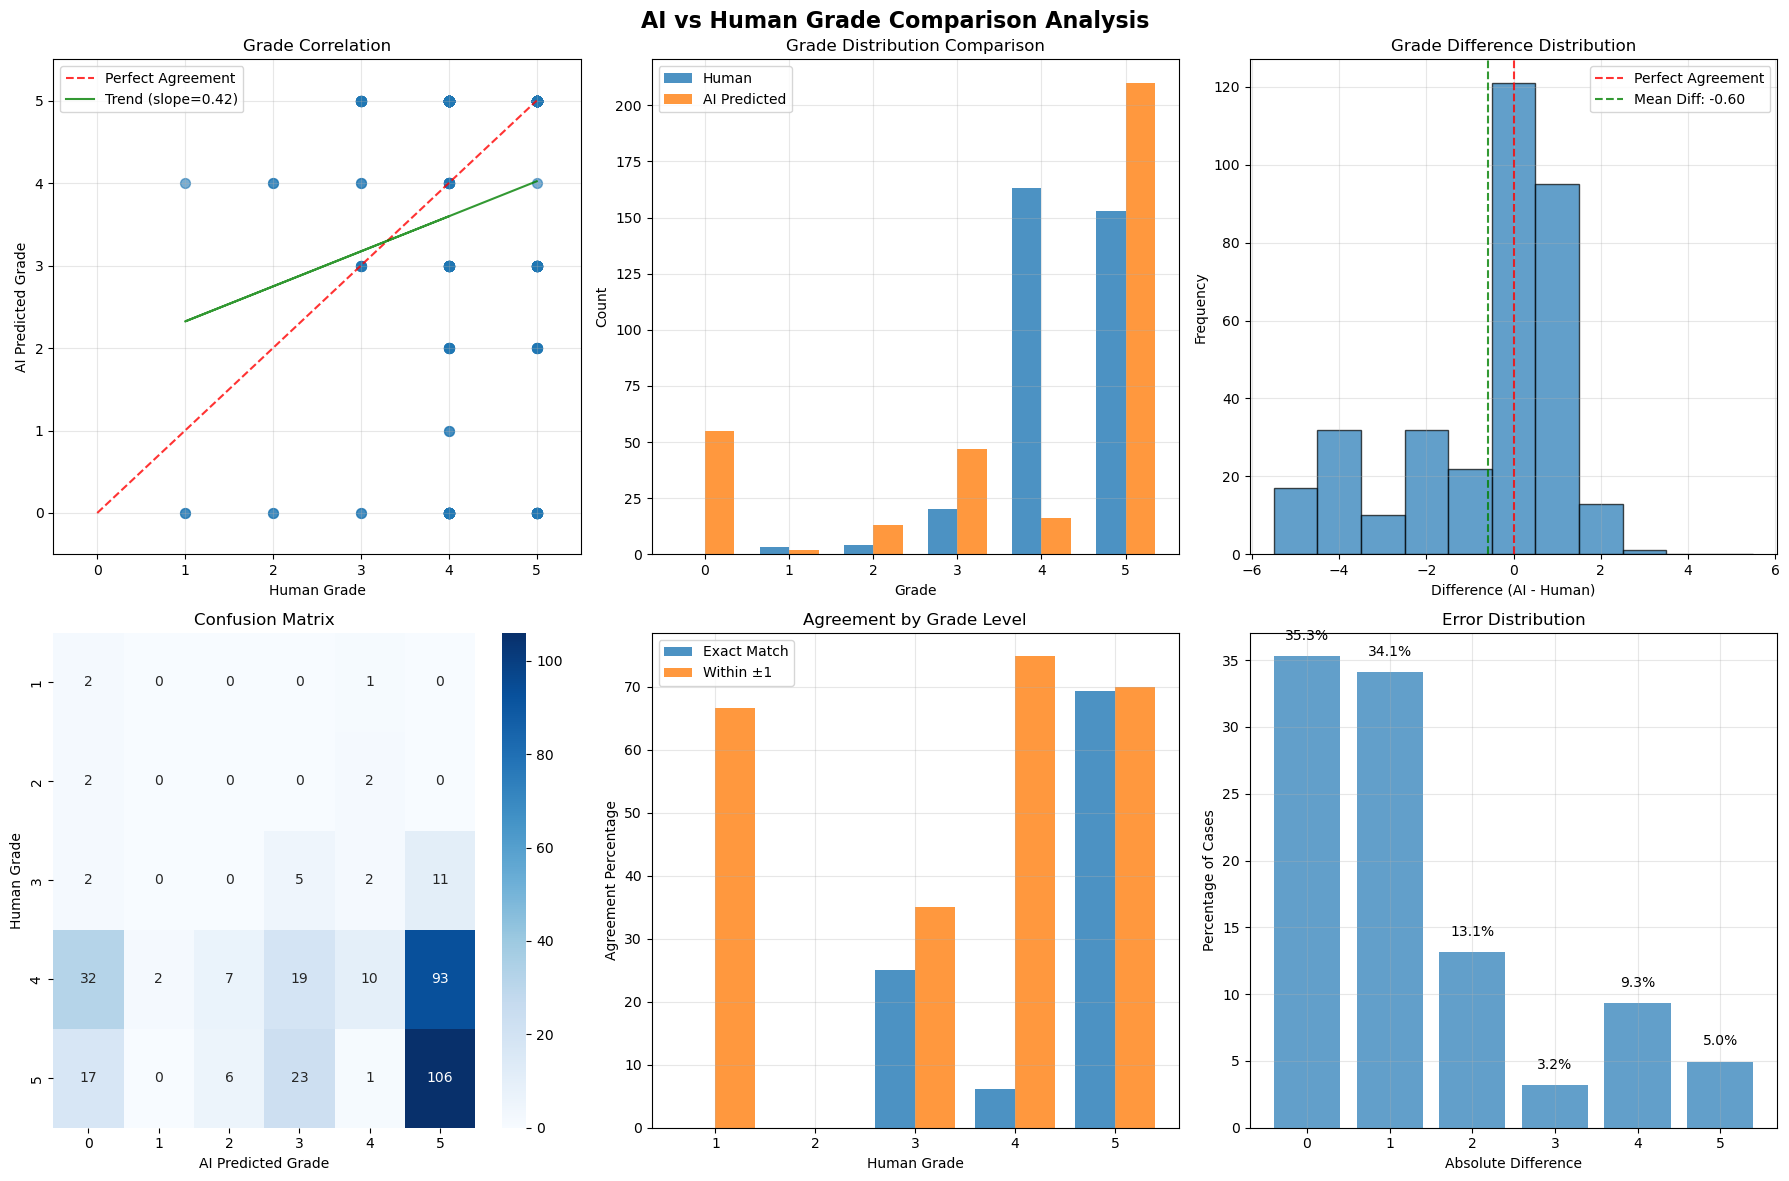


🎉 Analysis completed successfully!
📁 Generated files:
   - detailed_comparison.csv
   - grade_comparison_plots.png


In [3]:
#!/usr/bin/env python3
"""
Fixed Grade Comparison Tool
Handles the 'Failed: ' prefix and different structure in grading.json
"""

import json
import pandas as pd
import numpy as np
from collections import Counter
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt
import seaborn as sns

def parse_human_grades_file(human_path: str):
    """
    Parse the human grades file which has 'Failed: ' prefix and different structure.
    
    Expected structure:
    Failed: {
      "groupId": {
        "userStories": [
          {
            "userStory": "...",
            "comment": "...", 
            "grade": X
          }
        ]
      }
    }
    """
    print(f"📖 Reading human grades from {human_path}...")
    
    with open(human_path, "r", encoding="utf-8") as f:
        content = f.read()
    
    # Remove the "Failed: " prefix
    if content.startswith("Failed: "):
        content = content[8:]  # Remove "Failed: "
        print("   ✅ Removed 'Failed: ' prefix")
    
    # Parse JSON
    try:
        raw_data = json.loads(content)
        print(f"   ✅ Successfully parsed JSON with {len(raw_data)} groups")
    except json.JSONDecodeError as e:
        print(f"   ❌ JSON parsing failed: {e}")
        return None
    
    # Convert to expected format: groupId -> list of stories
    converted_data = {}
    total_stories = 0
    
    for group_id, group_data in raw_data.items():
        if "userStories" in group_data:
            stories = []
            for story_data in group_data["userStories"]:
                # Convert to expected format
                story = {
                    "userStory": story_data.get("userStory", ""),
                    "grade": story_data.get("grade"),
                    "comment": story_data.get("comment", ""),
                    "tags": []  # Human data doesn't have tags, so empty list
                }
                stories.append(story)
                total_stories += 1
            
            converted_data[group_id] = stories
    
    print(f"   ✅ Converted {total_stories} user stories from {len(converted_data)} groups")
    return converted_data

def compare_grades(predicted_path: str, human_path: str, output_report: str = None):
    """
    Compare AI-predicted grades with human grades and generate comprehensive statistics.
    
    Args:
        predicted_path: Path to AI-graded JSON file (output from your grader)
        human_path: Path to human-graded JSON file (with 'Failed: ' prefix)
        output_report: Optional path to save detailed report
    """
    print("🔍 Loading data...")
    
    # Load predicted grades
    with open(predicted_path, "r", encoding="utf-8") as f:
        predicted_data = json.load(f)
    print(f"   ✅ Loaded AI predictions: {len(predicted_data)} groups")
    
    # Load human grades using custom parser
    human_data = parse_human_grades_file(human_path)
    if human_data is None:
        return None
    
    # Flatten and match stories
    comparisons = []
    
    for group_id, stories in predicted_data.items():
        if group_id not in human_data:
            print(f"⚠️  Group {group_id} not found in human data")
            continue
            
        human_stories = human_data[group_id]
        
        for idx, pred_story in enumerate(stories):
            if idx >= len(human_stories):
                print(f"⚠️  Story {idx} in group {group_id} not found in human data")
                continue
                
            human_story = human_stories[idx]
            
            # Verify stories match
            pred_text = pred_story.get("userStory", "").strip()
            human_text = human_story.get("userStory", "").strip()
            
            if pred_text != human_text:
                print(f"⚠️  Story mismatch in group {group_id}, index {idx}")
                print(f"    Predicted: {pred_text[:50]}...")
                print(f"    Human: {human_text[:50]}...")
                continue
            
            # Extract grades
            pred_grade = pred_story.get("grade")
            human_grade = human_story.get("grade") 
            
            if pred_grade is not None and human_grade is not None:
                comparisons.append({
                    "group_id": group_id,
                    "story_idx": idx,
                    "story": pred_text,
                    "predicted_grade": pred_grade,
                    "human_grade": human_grade,
                    "predicted_tags": pred_story.get("tags", []),
                    "human_tags": human_story.get("tags", []),
                    "difference": pred_grade - human_grade,
                    "abs_difference": abs(pred_grade - human_grade)
                })
    
    if not comparisons:
        print("❌ No matching stories found!")
        return None
    
    print(f"✅ Found {len(comparisons)} matching stories")
    
    # Convert to DataFrame for easier analysis
    df = pd.DataFrame(comparisons)
    
    # ============ STATISTICAL ANALYSIS ============
    print("\n" + "="*60)
    print("📊 GRADE COMPARISON STATISTICS")
    print("="*60)
    
    # Basic stats
    pred_grades = df["predicted_grade"].values
    human_grades = df["human_grade"].values
    
    print(f"📈 Overall Statistics:")
    print(f"   Total comparisons: {len(df)}")
    print(f"   Perfect matches: {sum(df['difference'] == 0)} ({sum(df['difference'] == 0)/len(df)*100:.1f}%)")
    print(f"   Within ±1 point: {sum(df['abs_difference'] <= 1)} ({sum(df['abs_difference'] <= 1)/len(df)*100:.1f}%)")
    print(f"   Mean absolute error: {df['abs_difference'].mean():.2f}")
    print(f"   Root mean square error: {np.sqrt((df['difference']**2).mean()):.2f}")
    
    # Correlation
    pearson_corr, pearson_p = pearsonr(pred_grades, human_grades)
    spearman_corr, spearman_p = spearmanr(pred_grades, human_grades)
    
    print(f"\n🔗 Correlation Analysis:")
    print(f"   Pearson correlation: {pearson_corr:.3f} (p={pearson_p:.3f})")
    print(f"   Spearman correlation: {spearman_corr:.3f} (p={spearman_p:.3f})")
    
    # Grade distribution
    print(f"\n📊 Grade Distribution:")
    print("   Human grades:")
    human_dist = Counter(human_grades)
    for grade in sorted(human_dist.keys()):
        count = human_dist[grade]
        print(f"     Grade {grade}: {count} ({count/len(df)*100:.1f}%)")
    
    print("   Predicted grades:")
    pred_dist = Counter(pred_grades)
    for grade in sorted(pred_dist.keys()):
        count = pred_dist[grade]
        print(f"     Grade {grade}: {count} ({count/len(df)*100:.1f}%)")
    
    # Confusion Matrix
    print(f"\n🎯 Confusion Matrix (Human vs Predicted):")
    confusion = pd.crosstab(df["human_grade"], df["predicted_grade"], margins=True)
    print(confusion)
    
    # Agreement by grade level
    print(f"\n📋 Agreement by Grade Level:")
    for grade in sorted(set(human_grades)):
        subset = df[df["human_grade"] == grade]
        if len(subset) > 0:
            exact_match = sum(subset["difference"] == 0)
            within_1 = sum(subset["abs_difference"] <= 1)
            print(f"   Grade {grade}: {exact_match}/{len(subset)} exact ({exact_match/len(subset)*100:.1f}%), {within_1}/{len(subset)} within ±1 ({within_1/len(subset)*100:.1f}%)")
    
    # Bias analysis
    print(f"\n⚖️  Bias Analysis:")
    mean_diff = df["difference"].mean()
    if abs(mean_diff) < 0.1:
        bias_desc = "unbiased"
    elif mean_diff > 0:
        bias_desc = f"tends to overgrade by {mean_diff:.2f} points"
    else:
        bias_desc = f"tends to undergrade by {abs(mean_diff):.2f} points"
    print(f"   Mean difference (pred - human): {mean_diff:.2f}")
    print(f"   AI grader {bias_desc}")
    
    # Worst disagreements
    print(f"\n❌ Largest Disagreements:")
    worst = df.nlargest(5, "abs_difference")
    for _, row in worst.iterrows():
        print(f"   Story: {row['story'][:60]}...")
        print(f"   Human: {row['human_grade']}/5, AI: {row['predicted_grade']}/5 (diff: {row['difference']:+.0f})")
        print(f"   AI tags: {row['predicted_tags']}")
        print()
    
    # Save detailed report
    if output_report:
        print(f"\n💾 Saving detailed report to {output_report}")
        df.to_csv(output_report, index=False)
    
    return df

def plot_grade_comparison(df: pd.DataFrame, save_path: str = None):
    """
    Create comprehensive visualizations for grade comparison analysis.
    """
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('AI vs Human Grade Comparison Analysis', fontsize=16, fontweight='bold')
    
    # 1. Scatter plot with trend line
    axes[0,0].scatter(df['human_grade'], df['predicted_grade'], alpha=0.6, s=50)
    axes[0,0].plot([0, 5], [0, 5], 'r--', alpha=0.8, label='Perfect Agreement')
    
    # Add trend line
    z = np.polyfit(df['human_grade'], df['predicted_grade'], 1)
    p = np.poly1d(z)
    axes[0,0].plot(df['human_grade'], p(df['human_grade']), "g-", alpha=0.8, label=f'Trend (slope={z[0]:.2f})')
    
    axes[0,0].set_xlabel('Human Grade')
    axes[0,0].set_ylabel('AI Predicted Grade')
    axes[0,0].set_title('Grade Correlation')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    axes[0,0].set_xlim(-0.5, 5.5)
    axes[0,0].set_ylim(-0.5, 5.5)
    
    # 2. Grade distribution comparison
    grades = range(6)
    human_counts = [sum(df['human_grade'] == g) for g in grades]
    pred_counts = [sum(df['predicted_grade'] == g) for g in grades]
    
    x = np.arange(len(grades))
    width = 0.35
    
    axes[0,1].bar(x - width/2, human_counts, width, label='Human', alpha=0.8)
    axes[0,1].bar(x + width/2, pred_counts, width, label='AI Predicted', alpha=0.8)
    
    axes[0,1].set_xlabel('Grade')
    axes[0,1].set_ylabel('Count')
    axes[0,1].set_title('Grade Distribution Comparison')
    axes[0,1].set_xticks(x)
    axes[0,1].set_xticklabels(grades)
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    
    # 3. Difference histogram
    axes[0,2].hist(df['difference'], bins=11, range=(-5.5, 5.5), alpha=0.7, edgecolor='black')
    axes[0,2].axvline(x=0, color='red', linestyle='--', alpha=0.8, label='Perfect Agreement')
    axes[0,2].axvline(x=df['difference'].mean(), color='green', linestyle='--', alpha=0.8, 
                     label=f'Mean Diff: {df["difference"].mean():.2f}')
    axes[0,2].set_xlabel('Difference (AI - Human)')
    axes[0,2].set_ylabel('Frequency')
    axes[0,2].set_title('Grade Difference Distribution')
    axes[0,2].legend()
    axes[0,2].grid(True, alpha=0.3)
    
    # 4. Confusion matrix heatmap
    confusion = pd.crosstab(df['human_grade'], df['predicted_grade'])
    sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', ax=axes[1,0])
    axes[1,0].set_xlabel('AI Predicted Grade')
    axes[1,0].set_ylabel('Human Grade') 
    axes[1,0].set_title('Confusion Matrix')
    
    # 5. Agreement by grade level
    grade_levels = sorted(df['human_grade'].unique())
    exact_agreements = []
    within_1_agreements = []
    
    for grade in grade_levels:
        subset = df[df['human_grade'] == grade]
        exact = sum(subset['difference'] == 0) / len(subset) * 100
        within_1 = sum(subset['abs_difference'] <= 1) / len(subset) * 100
        exact_agreements.append(exact)
        within_1_agreements.append(within_1)
    
    x = np.arange(len(grade_levels))
    axes[1,1].bar(x - 0.2, exact_agreements, 0.4, label='Exact Match', alpha=0.8)
    axes[1,1].bar(x + 0.2, within_1_agreements, 0.4, label='Within ±1', alpha=0.8)
    
    axes[1,1].set_xlabel('Human Grade')
    axes[1,1].set_ylabel('Agreement Percentage')
    axes[1,1].set_title('Agreement by Grade Level')
    axes[1,1].set_xticks(x)
    axes[1,1].set_xticklabels(grade_levels)
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)
    
    # 6. Error analysis by absolute difference
    abs_diffs = sorted(df['abs_difference'].unique())
    error_counts = [sum(df['abs_difference'] == diff) for diff in abs_diffs]
    error_percentages = [count/len(df)*100 for count in error_counts]
    
    axes[1,2].bar(abs_diffs, error_percentages, alpha=0.7)
    axes[1,2].set_xlabel('Absolute Difference')
    axes[1,2].set_ylabel('Percentage of Cases')
    axes[1,2].set_title('Error Distribution')
    axes[1,2].grid(True, alpha=0.3)
    
    # Add percentage labels on bars
    for i, (diff, pct) in enumerate(zip(abs_diffs, error_percentages)):
        axes[1,2].text(diff, pct + 1, f'{pct:.1f}%', ha='center', va='bottom')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"📊 Visualization saved to {save_path}")
    
    plt.show()

def full_comparison_analysis(predicted_path: str, human_path: str):
    """
    Run complete comparison analysis with statistics and visualizations.
    """
    # Get comparison data
    df = compare_grades(predicted_path, human_path, "detailed_comparison.csv")
    
    if df is not None:
        # Generate visualizations  
        plot_grade_comparison(df, "grade_comparison_plots.png")
        
        return df
    else:
        print("❌ Comparison failed - check your input files")
        return None

if __name__ == "__main__":
    # Run the comparison
    print("🚀 Starting Fixed Grade Comparison Analysis...")
    
    comparison_results = full_comparison_analysis(
        predicted_path="graded_user_stories.json",
        human_path="grading.json"
    )
    
    if comparison_results is not None:
        print("\n🎉 Analysis completed successfully!")
        print("📁 Generated files:")
        print("   - detailed_comparison.csv")
        print("   - grade_comparison_plots.png")
    else:
        print("❌ Analysis failed!")


In [1]:
import json
from collections import defaultdict

# Tag penalties as defined in your system
TAG_PENALTIES = {
    "duplicate": -5,
    "irrelevant": -5,
    "vague": -2,
    "oversized": -2,
    "role-mismatch": -3,
    "ui-polish": -2,
    "typo": -1,
    "bad-structure": -3,
}

def group_user_stories_by_tags(input_file='graded_user_stories.json', output_file='stories_by_tags.json'):
    """
    Group user stories by their tags along with feedback and grades.
    """
    try:
        print(f"Reading user stories from '{input_file}'...")
        
        # Read the input JSON file
        with open(input_file, 'r', encoding='utf-8') as f:
            data = json.load(f)
        
        # Group stories by tags
        grouped_by_tags = defaultdict(list)
        
        # Process each student's stories
        for student_id, stories in data.items():
            for story in stories:
                # Get tags for this story
                story_tags = story.get('tags', [])
                
                # Create story entry with student info
                story_entry = {
                    'student_id': student_id,
                    'userStory': story.get('userStory', ''),
                    'grade': story.get('grade', 0),
                    'feedback': story.get('feedback', ''),
                    'tags': story_tags
                }
                
                # If story has no tags, put it in 'untagged' category
                if not story_tags:
                    grouped_by_tags['untagged'].append(story_entry)
                else:
                    # Add story to each tag category
                    for tag in story_tags:
                        grouped_by_tags[tag].append(story_entry)
        
        # Convert to regular dict
        result = dict(grouped_by_tags)
        
        # Save grouped data
        with open(output_file, 'w', encoding='utf-8') as f:
            json.dump(result, f, indent=2, ensure_ascii=False)
        
        print(f"✅ Successfully grouped user stories by tags")
        print(f"✅ Found {len(result)} different tag categories")
        print(f"✅ Saved to '{output_file}'")
        
        return result
        
    except Exception as e:
        print(f"❌ Error: {str(e)}")
        return None

def analyze_tag_performance(grouped_data):
    """
    Analyze performance and statistics for each tag category
    """
    analysis = {}
    
    for tag, stories in grouped_data.items():
        if not stories:
            continue
            
        grades = [story['grade'] for story in stories]
        penalty = TAG_PENALTIES.get(tag, 0)
        
        # Calculate statistics
        total_stories = len(stories)
        avg_grade = sum(grades) / total_stories
        min_grade = min(grades)
        max_grade = max(grades)
        
        # Grade distribution
        grade_dist = {str(i): 0 for i in range(6)}
        for grade in grades:
            grade_dist[str(int(grade))] += 1
        
        # Student distribution
        students = list(set(story['student_id'] for story in stories))
        
        analysis[tag] = {
            'tag_penalty': penalty,
            'story_count': total_stories,
            'student_count': len(students),
            'avg_grade': round(avg_grade, 2),
            'min_grade': min_grade,
            'max_grade': max_grade,
            'grade_distribution': grade_dist,
            'students_affected': students
        }
    
    return analysis

def create_tag_report(input_file='graded_user_stories.json'):
    """
    Create a comprehensive analysis of user stories grouped by tags
    """
    print("🔍 Starting user stories tag analysis...\n")
    
    # Step 1: Group stories by tags
    grouped_data = group_user_stories_by_tags(input_file, 'stories_by_tags.json')
    
    if not grouped_data:
        print("❌ Failed to group stories by tags")
        return None
    
    print("\n📊 Analyzing tag performance...")
    
    # Step 2: Analyze tag performance
    analysis = analyze_tag_performance(grouped_data)
    
    # Step 3: Save analysis to JSON
    with open('tag_analysis.json', 'w', encoding='utf-8') as f:
        json.dump(analysis, f, indent=2, ensure_ascii=False)
    
    print("✅ Analysis saved to 'tag_analysis.json'")
    
    # Step 4: Create human-readable report
    print("📝 Creating detailed report...")
    
    with open('tag_report.txt', 'w', encoding='utf-8') as f:
        f.write("USER STORIES TAG ANALYSIS REPORT\n")
        f.write("=" * 60 + "\n\n")
        
        # Overall summary
        total_stories = sum(len(stories) for stories in grouped_data.values())
        total_students = len(set(story['student_id'] for stories in grouped_data.values() for story in stories))
        
        f.write("📋 SUMMARY:\n")
        f.write("-" * 20 + "\n")
        f.write(f"Total Stories Analyzed: {total_stories}\n")
        f.write(f"Total Students: {total_students}\n")
        f.write(f"Tag Categories Found: {len(analysis)}\n")
        f.write(f"Stories per Student (avg): {total_stories / total_students:.1f}\n\n")
        
        # Tag overview sorted by penalty severity (most severe first)
        f.write("🏷️  TAG OVERVIEW (sorted by penalty severity):\n")
        f.write("-" * 50 + "\n")
        f.write(f"{'Tag':<15} {'Penalty':<8} {'Count':<6} {'Students':<9} {'Avg Grade':<10}\n")
        f.write("-" * 50 + "\n")
        
        sorted_tags = sorted(analysis.items(), key=lambda x: x[1]['tag_penalty'])
        for tag, data in sorted_tags:
            f.write(f"{tag:<15} {data['tag_penalty']:<8} {data['story_count']:<6} "
                   f"{data['student_count']:<9} {data['avg_grade']:<10}\n")
        
        f.write("\n" + "=" * 60 + "\n\n")
        
        # Detailed breakdown for each tag
        f.write("📊 DETAILED TAG ANALYSIS:\n\n")
        
        for tag, data in sorted(analysis.items(), key=lambda x: x[1]['story_count'], reverse=True):
            f.write(f"🏷️  {tag.upper()}\n")
            f.write("-" * 30 + "\n")
            f.write(f"Penalty: {data['tag_penalty']} points\n")
            f.write(f"Stories: {data['story_count']}\n")
            f.write(f"Students affected: {data['student_count']}\n")
            f.write(f"Average grade: {data['avg_grade']}/5\n")
            f.write(f"Grade range: {data['min_grade']} - {data['max_grade']}\n")
            
            # Grade distribution
            f.write("Grade distribution: ")
            for grade, count in data['grade_distribution'].items():
                if count > 0:
                    f.write(f"{grade}★({count}) ")
            f.write("\n")
            
            # List students (first 10)
            f.write(f"Students: {', '.join(data['students_affected'][:10])}")
            if len(data['students_affected']) > 10:
                f.write(f" ... and {len(data['students_affected']) - 10} more")
            f.write("\n\n")
            
            f.write("-" * 60 + "\n\n")
    
    print("✅ Detailed report saved to 'tag_report.txt'")
    
    # Step 5: Print summary to console
    print("\n🎯 KEY INSIGHTS:")
    print("-" * 40)
    
    # Most problematic tag (most severe penalty)
    if analysis:
        worst_tag = min(analysis.items(), key=lambda x: x[1]['tag_penalty'])
        print(f"Most severe issue: {worst_tag[0]} ({worst_tag[1]['story_count']} stories, {worst_tag[1]['tag_penalty']} pts each)")
        
        # Most common issue
        common_tag = max(analysis.items(), key=lambda x: x[1]['story_count'])
        print(f"Most common issue: {common_tag[0]} ({common_tag[1]['story_count']} stories)")
        
        # Show tag breakdown
        print(f"\nTag breakdown:")
        for tag, data in sorted(analysis.items(), key=lambda x: x[1]['story_count'], reverse=True):
            print(f"  • {tag}: {data['story_count']} stories ({data['student_count']} students)")
    
    print(f"\n📁 Files created:")
    print(f"   • stories_by_tags.json - Stories grouped by tags")
    print(f"   • tag_analysis.json - Detailed statistics")
    print(f"   • tag_report.txt - Human-readable report")
    
    return analysis

def print_tag_definitions():
    """
    Print what each tag means and its penalty
    """
    print("\n🏷️  TAG DEFINITIONS AND PENALTIES:")
    print("=" * 45)
    
    tag_descriptions = {
        "duplicate": "Story is a duplicate of another story",
        "irrelevant": "Story is outside the scope of ToDo app",
        "vague": "Story lacks specific details or clarity",
        "oversized": "Story is too complex, should be broken down",
        "role-mismatch": "Wrong user role specified for the context",
        "ui-polish": "Cosmetic feature, not core functionality",
        "typo": "Contains spelling or grammatical errors",
        "bad-structure": "Doesn't follow proper user story format"
    }
    
    for tag, penalty in sorted(TAG_PENALTIES.items(), key=lambda x: x[1]):
        desc = tag_descriptions.get(tag, "No description available")
        print(f"  {tag:<15} ({penalty:>2} pts): {desc}")
    
    print(f"  {'untagged':<15} ({0:>2} pts): No quality issues identified")

# Main execution
if __name__ == "__main__":
    import os
    
    print_tag_definitions()
    print("\n" + "="*60)
    
    # Check if the input file exists
    try:
        with open('graded_user_stories.json', 'r') as f:
            pass
        print("✅ Found 'graded_user_stories.json' file")
    except FileNotFoundError:
        print("❌ Error: 'graded_user_stories.json' file not found!")
        print("   Please make sure the file exists in the current directory.")
        print(f"   Current directory: {os.getcwd()}")
        print(f"   Files in directory: {os.listdir('.')}")
        exit()
    
    # Run the analysis
    analysis = create_tag_report()
    
    if analysis:
        print(f"\n✅ Analysis completed successfully!")
        
        # Show file locations and verify they exist
        print(f"\n📁 File verification:")
        files_to_check = ['stories_by_tags.json', 'tag_analysis.json', 'tag_report.txt']
        for filename in files_to_check:
            if os.path.exists(filename):
                size = os.path.getsize(filename)
                print(f"   ✅ {filename} ({size:,} bytes)")
            else:
                print(f"   ❌ {filename} - NOT FOUND")
        
        print(f"\n📂 Current working directory: {os.getcwd()}")
        
        # In Jupyter, also display a sample of the data
        print(f"\n📋 SAMPLE OF GROUPED DATA:")
        print("-" * 40)
        
        # Read and show sample from stories_by_tags.json
        try:
            with open('stories_by_tags.json', 'r') as f:
                grouped_data = json.load(f)
            
            # Show first few entries from each tag
            for tag, stories in list(grouped_data.items())[:3]:
                print(f"\n🏷️ {tag.upper()}: {len(stories)} stories")
                for i, story in enumerate(stories[:2]):
                    print(f"   {i+1}. Student {story['student_id']} (Grade: {story['grade']})")
                    story_preview = story['userStory'][:60] + "..." if len(story['userStory']) > 60 else story['userStory']
                    print(f"      \"{story_preview}\"")
                if len(stories) > 2:
                    print(f"      ... and {len(stories) - 2} more stories")
        except:
            print("Could not read sample data")
            
    else:
        print(f"\n❌ Analysis failed!")

# For Jupyter notebook users - add these helper functions
def show_files_in_current_directory():
    """Show all files in the current directory"""
    import os
    print("📁 Files in current directory:")
    files = os.listdir('.')
    for file in sorted(files):
        if os.path.isfile(file):
            size = os.path.getsize(file)
            print(f"   📄 {file} ({size:,} bytes)")
        else:
            print(f"   📁 {file}/")

def display_tag_analysis_summary():
    """Display a summary of the tag analysis (for Jupyter)"""
    try:
        with open('tag_analysis.json', 'r') as f:
            analysis = json.load(f)
        
        print("📊 TAG ANALYSIS SUMMARY:")
        print("=" * 50)
        
        # Create a simple table
        print(f"{'Tag':<15} {'Stories':<8} {'Students':<9} {'Avg Grade':<10} {'Penalty':<8}")
        print("-" * 50)
        
        for tag, data in sorted(analysis.items(), key=lambda x: x[1]['story_count'], reverse=True):
            print(f"{tag:<15} {data['story_count']:<8} {data['student_count']:<9} "
                  f"{data['avg_grade']:<10} {data['tag_penalty']:<8}")
                  
        return analysis
    except FileNotFoundError:
        print("❌ tag_analysis.json not found. Run create_tag_report() first.")
        return None

def show_stories_for_tag(tag_name):
    """Show all stories for a specific tag"""
    try:
        with open('stories_by_tags.json', 'r') as f:
            grouped_data = json.load(f)
        
        if tag_name not in grouped_data:
            print(f"❌ Tag '{tag_name}' not found.")
            print(f"Available tags: {', '.join(grouped_data.keys())}")
            return
        
        stories = grouped_data[tag_name]
        print(f"🏷️ {tag_name.upper()}: {len(stories)} stories")
        print("=" * 50)
        
        for i, story in enumerate(stories, 1):
            print(f"\n{i}. Student: {story['student_id']} | Grade: {story['grade']}")
            print(f"   Story: \"{story['userStory']}\"")
            print(f"   Feedback: {story['feedback']}")
            
    except FileNotFoundError:
        print("❌ stories_by_tags.json not found. Run create_tag_report() first.")

# Add these functions for easy access in Jupyter
print("\n💡 Jupyter Helper Functions Available:")
print("   • show_files_in_current_directory() - List all files")
print("   • display_tag_analysis_summary() - Show analysis table") 
print("   • show_stories_for_tag('tag_name') - Show stories for specific tag")
print("   • create_tag_report() - Run the full analysis")


🏷️  TAG DEFINITIONS AND PENALTIES:
  duplicate       (-5 pts): Story is a duplicate of another story
  irrelevant      (-5 pts): Story is outside the scope of ToDo app
  role-mismatch   (-3 pts): Wrong user role specified for the context
  bad-structure   (-3 pts): Doesn't follow proper user story format
  vague           (-2 pts): Story lacks specific details or clarity
  oversized       (-2 pts): Story is too complex, should be broken down
  ui-polish       (-2 pts): Cosmetic feature, not core functionality
  typo            (-1 pts): Contains spelling or grammatical errors
  untagged        ( 0 pts): No quality issues identified

✅ Found 'graded_user_stories.json' file
🔍 Starting user stories tag analysis...

Reading user stories from 'graded_user_stories.json'...
✅ Successfully grouped user stories by tags
✅ Found 9 different tag categories
✅ Saved to 'stories_by_tags.json'

📊 Analyzing tag performance...
✅ Analysis saved to 'tag_analysis.json'
📝 Creating detailed report...
✅ Deta

In [2]:
import json
from collections import Counter

def analyze_grades(input_file='graded_user_stories.json'):
    """
    Analyze grades from user stories - show average and distribution
    """
    try:
        # Read the graded user stories
        with open(input_file, 'r', encoding='utf-8') as f:
            data = json.load(f)
        
        # Collect all grades
        all_grades = []
        grade_counter = Counter()
        
        total_stories = 0
        total_students = len(data)
        
        # Extract grades from all stories
        for student_id, stories in data.items():
            for story in stories:
                grade = story.get('grade', 0)
                all_grades.append(grade)
                grade_counter[int(grade)] += 1
                total_stories += 1
        
        # Calculate average
        if all_grades:
            average_grade = sum(all_grades) / len(all_grades)
        else:
            average_grade = 0
        
        # Print results
        print("📊 GRADE ANALYSIS REPORT")
        print("=" * 40)
        print(f"Total Stories: {total_stories}")
        print(f"Total Students: {total_students}")
        print(f"Average Grade: {average_grade:.2f}/5")
        print()
        
        print("📈 GRADE DISTRIBUTION:")
        print("-" * 30)
        
        # Show distribution for grades 0-5
        for grade in range(6):
            count = grade_counter.get(grade, 0)
            percentage = (count / total_stories * 100) if total_stories > 0 else 0
            stars = "★" * grade if grade > 0 else "☆"
            bar = "█" * int(percentage // 2)  # Visual bar
            
            print(f"Grade {grade} {stars:<5}: {count:4d} stories ({percentage:5.1f}%) {bar}")
        
        print()
        print("📋 SUMMARY STATISTICS:")
        print("-" * 25)
        print(f"Highest Grade: {max(all_grades) if all_grades else 0}")
        print(f"Lowest Grade: {min(all_grades) if all_grades else 0}")
        print(f"Most Common Grade: {grade_counter.most_common(1)[0][0] if grade_counter else 'N/A'}")
        
        # Calculate some interesting stats
        perfect_stories = grade_counter.get(5, 0)
        failed_stories = grade_counter.get(0, 0)
        passed_stories = sum(grade_counter.get(i, 0) for i in range(3, 6))  # Grades 3, 4, 5
        
        print(f"Perfect Stories (5★): {perfect_stories} ({perfect_stories/total_stories*100:.1f}%)")
        print(f"Failed Stories (0★): {failed_stories} ({failed_stories/total_stories*100:.1f}%)")
        print(f"Passing Stories (3★+): {passed_stories} ({passed_stories/total_stories*100:.1f}%)")
        
        return {
            'total_stories': total_stories,
            'total_students': total_students,
            'average_grade': average_grade,
            'grade_distribution': dict(grade_counter),
            'all_grades': all_grades
        }
        
    except FileNotFoundError:
        print(f"❌ Error: File '{input_file}' not found!")
        return None
    except Exception as e:
        print(f"❌ Error analyzing grades: {str(e)}")
        return None

def analyze_grades_by_tag(input_file='graded_user_stories.json'):
    """
    Analyze grades broken down by tag categories
    """
    try:
        # Read the graded user stories
        with open(input_file, 'r', encoding='utf-8') as f:
            data = json.load(f)
        
        # Group grades by tags
        tag_grades = {}
        
        for student_id, stories in data.items():
            for story in stories:
                grade = story.get('grade', 0)
                tags = story.get('tags', [])
                
                # If no tags, use 'untagged'
                if not tags:
                    tags = ['untagged']
                
                for tag in tags:
                    if tag not in tag_grades:
                        tag_grades[tag] = []
                    tag_grades[tag].append(grade)
        
        print("\n📊 GRADE ANALYSIS BY TAG")
        print("=" * 60)
        print(f"{'Tag':<15} {'Count':<6} {'Avg':<6} {'0★':<4} {'1★':<4} {'2★':<4} {'3★':<4} {'4★':<4} {'5★':<4}")
        print("-" * 60)
        
        # Sort by average grade (lowest first to show problem areas)
        for tag, grades in sorted(tag_grades.items(), key=lambda x: sum(x[1])/len(x[1])):
            count = len(grades)
            avg = sum(grades) / count
            
            # Count each grade
            grade_counts = Counter(int(g) for g in grades)
            
            print(f"{tag:<15} {count:<6} {avg:<6.2f} ", end="")
            for grade in range(6):
                print(f"{grade_counts.get(grade, 0):<4}", end="")
            print()
        
        return tag_grades
        
    except Exception as e:
        print(f"❌ Error analyzing grades by tag: {str(e)}")
        return None

def analyze_student_performance(input_file='graded_user_stories.json', show_top=10):
    """
    Analyze individual student performance
    """
    try:
        # Read the graded user stories
        with open(input_file, 'r', encoding='utf-8') as f:
            data = json.load(f)
        
        student_stats = {}
        
        for student_id, stories in data.items():
            grades = [story.get('grade', 0) for story in stories]
            
            student_stats[student_id] = {
                'total_stories': len(stories),
                'average_grade': sum(grades) / len(grades) if grades else 0,
                'grades': grades,
                'grade_distribution': Counter(int(g) for g in grades)
            }
        
        print(f"\n👥 STUDENT PERFORMANCE ANALYSIS")
        print("=" * 50)
        
        # Top performers
        top_students = sorted(student_stats.items(), key=lambda x: x[1]['average_grade'], reverse=True)
        
        print(f"\n🏆 TOP {show_top} PERFORMERS:")
        print("-" * 35)
        print(f"{'Student':<10} {'Stories':<8} {'Avg Grade':<10}")
        print("-" * 35)
        
        for student_id, stats in top_students[:show_top]:
            print(f"{student_id:<10} {stats['total_stories']:<8} {stats['average_grade']:<10.2f}")
        
        # Bottom performers
        print(f"\n📉 BOTTOM {show_top} PERFORMERS:")
        print("-" * 35)
        print(f"{'Student':<10} {'Stories':<8} {'Avg Grade':<10}")
        print("-" * 35)
        
        for student_id, stats in top_students[-show_top:]:
            print(f"{student_id:<10} {stats['total_stories']:<8} {stats['average_grade']:<10.2f}")
        
        return student_stats
        
    except Exception as e:
        print(f"❌ Error analyzing student performance: {str(e)}")
        return None

def quick_grade_stats(input_file='graded_user_stories.json'):
    """
    Quick one-liner grade statistics
    """
    try:
        with open(input_file, 'r', encoding='utf-8') as f:
            data = json.load(f)
        
        all_grades = []
        for stories in data.values():
            for story in stories:
                all_grades.append(story.get('grade', 0))
        
        if not all_grades:
            print("No grades found!")
            return
        
        avg = sum(all_grades) / len(all_grades)
        grade_counts = Counter(int(g) for g in all_grades)
        
        print(f"📊 Quick Stats: {len(all_grades)} stories, Avg: {avg:.2f}/5")
        print(f"Distribution: ", end="")
        for grade in range(6):
            count = grade_counts.get(grade, 0)
            print(f"{grade}★:{count} ", end="")
        print()
        
    except Exception as e:
        print(f"❌ Error: {str(e)}")

# Run all analyses
if __name__ == "__main__":
    print("🎯 COMPREHENSIVE GRADE ANALYSIS")
    print("=" * 50)
    
    # Main grade analysis
    grade_data = analyze_grades()
    
    if grade_data:
        # Grade analysis by tag
        analyze_grades_by_tag()
        
        # Student performance analysis
        analyze_student_performance()

# Helper functions for Jupyter
print("\n💡 Available Functions:")
print("   • analyze_grades() - Main grade analysis with distribution")
print("   • analyze_grades_by_tag() - Grade breakdown by tag categories") 
print("   • analyze_student_performance() - Individual student stats")
print("   • quick_grade_stats() - One-liner summary")

🎯 COMPREHENSIVE GRADE ANALYSIS
📊 GRADE ANALYSIS REPORT
Total Stories: 351
Total Students: 174
Average Grade: 3.69/5

📈 GRADE DISTRIBUTION:
------------------------------
Grade 0 ☆    :   59 stories ( 16.8%) ████████
Grade 1 ★    :    2 stories (  0.6%) 
Grade 2 ★★   :   13 stories (  3.7%) █
Grade 3 ★★★  :   51 stories ( 14.5%) ███████
Grade 4 ★★★★ :   16 stories (  4.6%) ██
Grade 5 ★★★★★:  210 stories ( 59.8%) █████████████████████████████

📋 SUMMARY STATISTICS:
-------------------------
Highest Grade: 5
Lowest Grade: 0
Most Common Grade: 5
Perfect Stories (5★): 210 (59.8%)
Failed Stories (0★): 59 (16.8%)
Passing Stories (3★+): 277 (78.9%)

📊 GRADE ANALYSIS BY TAG
Tag             Count  Avg    0★   1★   2★   3★   4★   5★  
------------------------------------------------------------
irrelevant      9      0.00   9   0   0   0   0   0   
duplicate       46     0.00   46  0   0   0   0   0   
bad-structure   2      0.00   2   0   0   0   0   0   
role-mismatch   14     1.64   2   1   11